# Total 0-75

In [1]:
#%pip install shap
#%matplotlib inline
#%pip install catboost

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap

from catboost import Pool, CatBoostRegressor, cv

# Data

In [3]:
df = pd.read_stata('W:\COVID19\std_inz0_75.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [4]:
#df.head()

In [30]:
Y = df['std_inz_0to75']
X = df.loc[:, ~df.columns.isin(['std_inz_0to75', 'eastwest'])]
f_names = list(X.columns)
print("Number of features: ", len(X.columns))

Number of features:  162


# RF model

In [6]:
rfr = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5000, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)
rf=rfr.fit(X, Y)  

# R2 RF model

In [7]:
rf.score(X, Y)

0.8169438303301793

# CatBoost Model (default)

In [8]:
# initialize Pool
train_pool = Pool(data=X,
                  label=Y,
                 feature_names = f_names)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0,
                          logging_level="Silent"
                         )
#train the model
cb = model.fit(train_pool)

In [9]:
# prediction
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )
#print(Y.dtype)
preds = preds.reshape(-1, 1)
#print(preds)
from sklearn.linear_model import LinearRegression
from sklearn import metrics
reg = LinearRegression().fit(preds, Y)
print("R2 linReg_model: ", reg.score(preds, Y))
print("RMSE linReg_model: ",metrics.mean_squared_error(preds, Y))


R2 linReg_model:  0.9994763018403688
RMSE linReg_model:  0.12320259574141135


In [10]:
cb.score(X, Y)

0.9994066010320601

# Grid-search CatBoost to obtain the optimal hyperparameters

model = CatBoostRegressor(random_seed=0,
                         custom_metric = 'R2',
                         early_stopping_rounds=50)

grid = {'learning_rate': [0.03, 0.01],
        'depth': [4, 6, 10],
        'num_trees': [1000, 2000, 10000]}

grid_search_result = model.grid_search(grid, 
                                       X=X, 
                                       y=Y,
                                       cv= int(5),
                                       plot=True)

grid_search_result['params'] #of best-found parameters.

# Final CatBoost Model 

# initialize Pool
train_pool = Pool(data=X,
                  label=Y,
                 feature_names = f_names)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0,
                          logging_level="Silent",
                          learning_rate = 0.03,
                          num_trees = 1000 ,
                          depth = 10
                         )
#train the model
cb_final = model.fit(train_pool)

# prediction
preds_final = cb_final.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )
#print(Y.dtype)
preds_final = preds_final.reshape(-1, 1)
#print(preds)
from sklearn.linear_model import LinearRegression
from sklearn import metrics
reg = LinearRegression().fit(preds_final, Y)
print("R2 LinReg: ",reg.score(preds_final, Y))
metrics.mean_squared_error(preds_final, Y)
print("R2 CatBoost: ", cb_final.score(X, Y))

# SHAP values 

# RF

In [12]:
shap_values = shap.TreeExplainer(rf).shap_values(X)

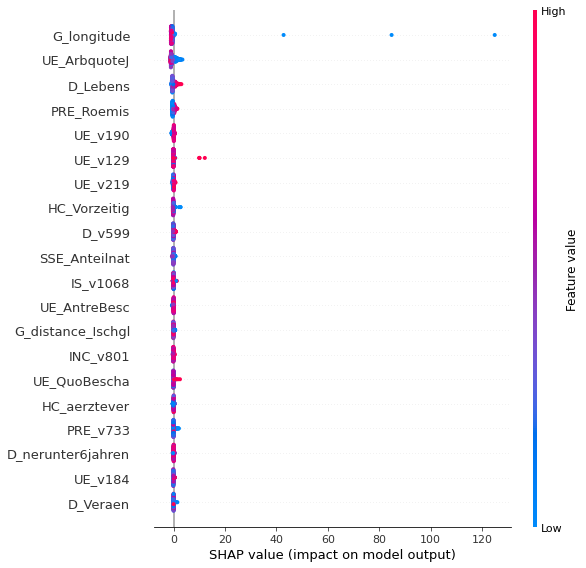

In [13]:
shap.summary_plot(shap_values, X,max_display=20) 

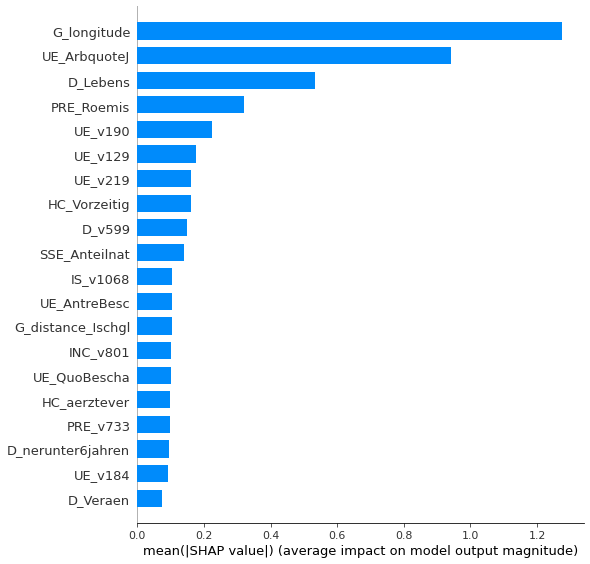

In [14]:
shap.summary_plot(shap_values, X, plot_type="bar",max_display=20)

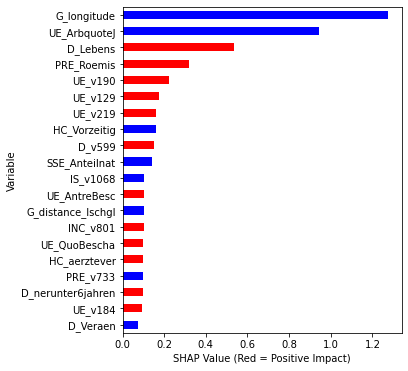

In [15]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    k2 = k2[-20:]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X) 

# CatBoost

In [16]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

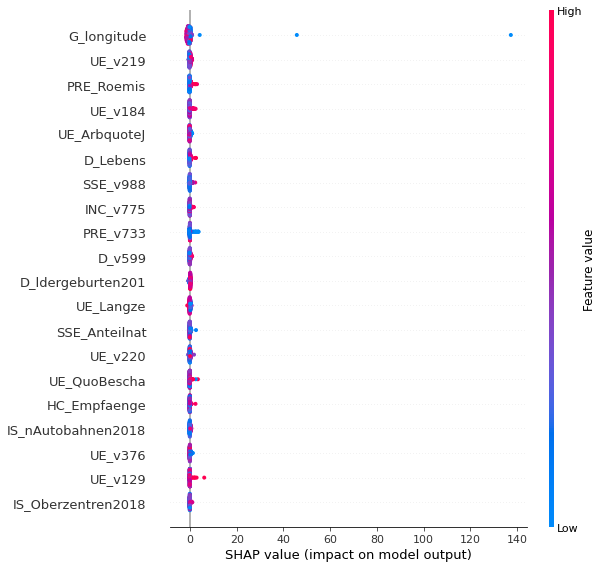

In [17]:
shap.summary_plot(shap_values_cb, X,max_display=20)  #TreeExpliner

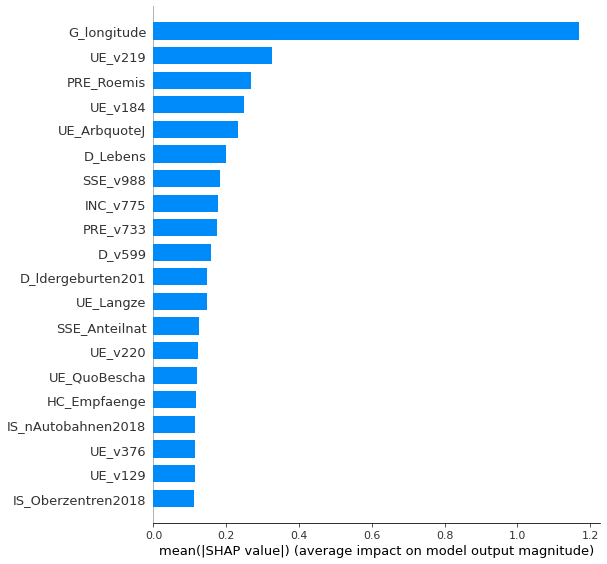

In [18]:
shap.summary_plot(shap_values_cb, X, plot_type="bar",max_display=20)

invalid value encountered in true_divide
invalid value encountered in true_divide


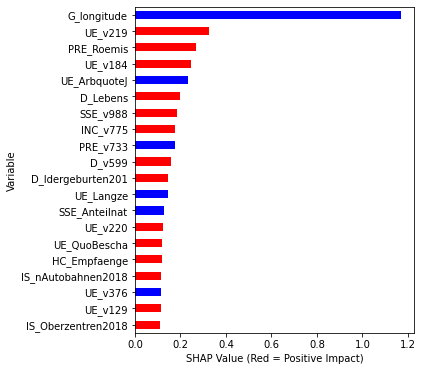

In [19]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    k2 = k2[-20:]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

# CatBoost 20 most important vars

In [20]:
f = len(X.columns)
l = f-21
ll = f-11


In [21]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][f:l:-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][f:ll:-1]

X[top20feature].describe()

,G_longitude,UE_v219,PRE_Roemis,UE_v184,UE_ArbquoteJ,D_Lebens,SSE_v988,INC_v775,PRE_v733,D_v599,D_ldergeburten201,UE_Langze,SSE_Anteilnat,UE_v220,UE_QuoBescha,HC_Empfaenge,IS_nAutobahnen2018,UE_v376,UE_v129,IS_Oberzentren2018
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,9.866996,12.901742,32.242809,2.814465,5.259102,80.655960,33367.324219,14.988533,13.063090,23.700602,16.510975,32.202751,5.101742,34.556618,52.529175,50.857368,11.857856,20.240156,5.669324,22.563591
std,2.026269,2.768405,24.361435,3.325890,2.706737,1.012629,30681.785156,4.460500,6.197584,0.656121,8.783781,8.077894,3.710643,13.284163,3.597842,6.518343,8.366137,4.537329,9.243236,16.033613
min,6.083333,6.100000,1.700000,-7.200000,1.400000,77.860001,1062.000000,1.000000,5.600000,22.020000,-9.600000,10.500000,0.900000,4.600000,40.400002,28.600000,0.000000,10.800000,-22.299999,0.000000
25%,8.216666,11.100000,7.900000,0.500000,2.900000,80.010002,15678.000000,12.600000,8.900000,23.270000,11.700000,25.600000,2.700000,26.100000,50.500000,46.400002,6.000000,17.000000,1.000000,13.000000
50%,9.766666,12.900000,29.100000,3.100000,4.900000,80.629997,24587.000000,15.000000,10.900000,23.680000,17.600000,32.700001,4.300000,32.000000,52.700001,51.099998,10.000000,19.299999,8.500000,23.000000
75%,11.416667,14.800000,52.299999,5.100000,6.600000,81.440002,39522.000000,17.700001,15.000000,24.180000,21.900000,38.500000,6.300000,41.400002,55.099998,55.599998,15.000000,22.400000,12.000000,32.000000
max,14.983334,21.900000,87.800003,12.400000,16.500000,83.599998,174293.000000,35.599998,42.900002,25.719999,45.500000,53.400002,34.000000,101.000000,60.799999,66.699997,53.000000,38.500000,26.600000,69.000000


In [22]:
# initialize Pool
train_pool20 = Pool(data=X[top20feature],
                  label=Y,
                 feature_names = list(X[top20feature].columns))
 

# specify the training parameters 
model20 = CatBoostRegressor(random_seed=0,
                          logging_level="Silent"
                         )
#train the model
cb20 = model20.fit(train_pool20)

In [23]:
# prediction
preds20 = cb20.predict(train_pool20,
                    prediction_type="RawFormulaVal"
                  )
#print(Y.dtype)
preds20 = preds20.reshape(-1, 1)
#print(preds20)
from sklearn.linear_model import LinearRegression
from sklearn import metrics
reg20 = LinearRegression().fit(preds20, Y)
print("R2 linReg_model20: ", reg.score(preds20, Y))
print("RMSE linReg_model20: ",metrics.mean_squared_error(preds20, Y))


R2 linReg_model20:  0.9969570811979839
RMSE linReg_model20:  0.6772394792445146


# R2 CatBoost top20

In [24]:
cb20.score(X[top20feature], Y)

0.9967381108684165

# cross validation

In [25]:
# all
import random
iterations = range(0,40)
r2_reg_k_test = list(range(0,40))
rmse_reg_k_test = list(range(0,40))
r2_cb_k_train = list(range(0,40))
r2_cb_k_test = list(range(0,40))
for i in iterations:
    rs = random.sample(range(0,401), 100)
    k_test_x = X.iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X.drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X.columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X.columns))
 
    model = CatBoostRegressor(random_seed=0, logging_level="Silent")
    #train the model
    cb_k = model.fit(train_pool_k)
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    from sklearn.linear_model import LinearRegression
    from sklearn import metrics
    reg_k = LinearRegression().fit(preds_k, k_test_y)
    print(i/len(iterations)*100, "% done; "," R2_reg_test:",reg_k.score(preds_k, k_test_y)) 
    #print("RMSE",metrics.mean_squared_error(preds_k, k_test_y)) 
    #print("R2_cb_train:",cb_k.score(train_pool_k)) 
    #print("R2_cb_test:",cb_k.score(test_pool_k))
    
    r2_reg_k_test[i] = reg_k.score(preds_k, k_test_y)
    rmse_reg_k_test[i] = metrics.mean_squared_error(preds_k, k_test_y)
    r2_cb_k_train[i] = cb_k.score(train_pool_k)
    r2_cb_k_test[i] =  cb_k.score(test_pool_k)

0.0 % done;   R2_reg_test: 0.007226354648324218
2.5 % done;   R2_reg_test: 0.05163366001393355
5.0 % done;   R2_reg_test: 0.15755858887427965
7.5 % done;   R2_reg_test: 0.02073312053279308
10.0 % done;   R2_reg_test: 0.15899644956555392
12.5 % done;   R2_reg_test: 0.009293397154516603
15.0 % done;   R2_reg_test: 0.26970483082432684
17.5 % done;   R2_reg_test: 0.011602002415599943
20.0 % done;   R2_reg_test: 0.030494508876426463
22.5 % done;   R2_reg_test: 0.12694554514717804
25.0 % done;   R2_reg_test: 0.22702968022505887
27.500000000000004 % done;   R2_reg_test: 0.05513718632865561
30.0 % done;   R2_reg_test: 0.34542580528628597
32.5 % done;   R2_reg_test: 0.047304434644210636
35.0 % done;   R2_reg_test: 0.016231477366590807
37.5 % done;   R2_reg_test: 0.14870469102242023
40.0 % done;   R2_reg_test: 0.05326130636463855
42.5 % done;   R2_reg_test: 0.19102321501825348
45.0 % done;   R2_reg_test: 0.19317020653055716
47.5 % done;   R2_reg_test: 0.13172733276457915
50.0 % done;   R2_reg_te

In [26]:
print("Mean R2 of linReg_modesl: ", sum(r2_reg_k_test)/len(r2_reg_k_test))
print("Mean R2 of CatBoost_models:",sum(r2_cb_k_train)/len(r2_cb_k_train))

Mean R2 of linReg_modesl:  0.12000570929792706
Mean R2 of CatBoost_models: 0.9996790873670559


In [27]:
import random
iterations = range(0,40)
r2_reg_k_test = list(range(0,40))
rmse_reg_k_test = list(range(0,40))
r2_cb_k_train = list(range(0,40))
r2_cb_k_test = list(range(0,40))
for i in iterations:
    rs = random.sample(range(0,401), 100)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))
 
    model = CatBoostRegressor(random_seed=0, logging_level="Silent")
    #train the model
    cb_k = model.fit(train_pool_k)
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    from sklearn.linear_model import LinearRegression
    from sklearn import metrics
    reg_k = LinearRegression().fit(preds_k, k_test_y)
    print(i/len(iterations)*100, "% done; "," R2_reg_test:",reg_k.score(preds_k, k_test_y)) 
    #print("RMSE",metrics.mean_squared_error(preds_k, k_test_y)) 
    #print("R2_cb_train:",cb_k.score(train_pool_k)) 
    #print("R2_cb_test:",cb_k.score(test_pool_k))
    
    r2_reg_k_test[i] = reg_k.score(preds_k, k_test_y)
    rmse_reg_k_test[i] = metrics.mean_squared_error(preds_k, k_test_y)
    r2_cb_k_train[i] = cb_k.score(train_pool_k)
    r2_cb_k_test[i] =  cb_k.score(test_pool_k)

0.0 % done;   R2_reg_test: 0.21416846351991647
2.5 % done;   R2_reg_test: 0.2537553432248173
5.0 % done;   R2_reg_test: 0.22091314987578226
7.5 % done;   R2_reg_test: 0.12483996804503594
10.0 % done;   R2_reg_test: 0.05956767327808854
12.5 % done;   R2_reg_test: 0.1513094741763843
15.0 % done;   R2_reg_test: 0.08632558605702623
17.5 % done;   R2_reg_test: 0.05270947272945725
20.0 % done;   R2_reg_test: 0.26545263576189215
22.5 % done;   R2_reg_test: 0.19998573464883562
25.0 % done;   R2_reg_test: 0.2193913983445921
27.500000000000004 % done;   R2_reg_test: 0.06858272461300263
30.0 % done;   R2_reg_test: 0.0424235559116104
32.5 % done;   R2_reg_test: 0.06494692333221785
35.0 % done;   R2_reg_test: 0.2622600660033514
37.5 % done;   R2_reg_test: 0.15374655802308346
40.0 % done;   R2_reg_test: 0.04291225854556202
42.5 % done;   R2_reg_test: 0.2607651371479317
45.0 % done;   R2_reg_test: 0.09359367714232292
47.5 % done;   R2_reg_test: 0.1946304207117021
50.0 % done;   R2_reg_test: 0.0918290

In [28]:
print("Mean R2 of linReg_modesl: ", sum(r2_reg_k_test)/len(r2_reg_k_test))
print("Mean R2 of CatBoost_models:",sum(r2_cb_k_train)/len(r2_cb_k_train))

Mean R2 of linReg_modesl:  0.15536129485697017
Mean R2 of CatBoost_models: 0.9977782704561973
